<a href="https://colab.research.google.com/github/lucasgneccoh/SGD_ICP_PY/blob/main/main_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install authors implementation

In [219]:
%%capture
%cd /content
!git clone https://bitbucket.org/fafz/sgd_icp.git
!sudo apt install libeigen3-dev
!sudo apt install libpcl-dev
%cd /content/sgd_icp
!mkdir build
%cd build
!cmake -DCMAKE_BUILD_TYPE=Release /content/sgd_icp
!make

# Project - SGD ICP in python
Excecute this cell to import modules and define functions

In [1]:
# Clone the repository in the Colab drive
# Build and Install pypcd to deal with pcd format clouds
%%capture
%cd /content
!git clone https://github.com/lucasgneccoh/SGD_ICP_PY.git
!pip install lzf
'''
Setup pypcd
'''
%cd /content/SGD_ICP_PY/pypcd/
!python setup.py build
!python setup.py install

In [2]:
%cd /content/SGD_ICP_PY/sgd_icp_python
import os
import numpy as np
from pypcd import pypcd as pcd
from google.colab import files
import json
import matplotlib.pyplot as plt
# Import numpy package and name it "np"
import numpy as np

# Import library to plot in python
from matplotlib import pyplot as plt

# Import functions from scikit-learn
from sklearn.neighbors import KDTree

# Import functions to read and write ply files
from ply_utils import write_ply, read_ply
from visu import show_ICP
import time

import torch
from tqdm.notebook import trange, tqdm
import plotly.express as px
import pandas as pd

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def quaternion_rotation_matrix(Q):
    """
    Covert a quaternion into a full three-dimensional rotation matrix.
 
    Input
    :param Q: A 4 element array representing the quaternion (q0,q1,q2,q3) 
 
    Output
    :return: A 3x3 element matrix representing the full 3D rotation matrix. 
             This rotation matrix converts a point in the local reference 
             frame to a point in the global reference frame.
    """
    # Extract the values from Q
    q0 = Q[0]
    q1 = Q[1]
    q2 = Q[2]
    q3 = Q[3]
     
    # First row of the rotation matrix
    r00 = 2 * (q0 * q0 + q1 * q1) - 1
    r01 = 2 * (q1 * q2 - q0 * q3)
    r02 = 2 * (q1 * q3 + q0 * q2)
     
    # Second row of the rotation matrix
    r10 = 2 * (q1 * q2 + q0 * q3)
    r11 = 2 * (q0 * q0 + q2 * q2) - 1
    r12 = 2 * (q2 * q3 - q0 * q1)
     
    # Third row of the rotation matrix
    r20 = 2 * (q1 * q3 - q0 * q2)
    r21 = 2 * (q2 * q3 + q0 * q1)
    r22 = 2 * (q0 * q0 + q3 * q3) - 1
     
    # 3x3 rotation matrix
    rot_matrix = np.array([[r00, r01, r02],
                           [r10, r11, r12],
                           [r20, r21, r22]])
                            
    return rot_matrix

def pitch_roll_yaw(ax, ay, az):
  cx, sx = np.cos(ax), np.sin(ax)
  cy, sy = np.cos(ay), np.sin(ay)
  cz, sz = np.cos(az), np.sin(az)
  
  R = np.array([[cz*cy, cz*sx*sy-sz*cx, cz*sx*sy+sz*sy],
                [sz*cy, sz*sx*sy+cz*cx, sz*sx*sy-cz*sx],
                [-sy, cy*sx, cy*cx]])
  return R

def d_R(ax, ay, az):
  cx, sx = np.cos(ax), np.sin(ax)
  cy, sy = np.cos(ay), np.sin(ay)
  cz, sz = np.cos(az), np.sin(az)
  
  d_roll = np.array([[0, 0, 0],
                [cx*sy*cz-sx*sz, -cx*sy*sz-sx*cz, -cx*cy],
                [sx*sy*cz + cx*sz, -sx*sy*sz+cx*cz,-sx*cy]])
  
  d_pitch = np.array([[-sy*cz, sy*sz, cy],
                [sx*cy*cz, -sx*cy*sz, sx*sy],
                [-cx*cy*cz, cx*cy*sz, -cx*sy]])
  
  d_yaw = np.array([[-cy*sz, -cy*cz, 0],
                [-sx*sy*sz+cx*cz, -sx*sy*cz-cx*sz, 0],
                [cx*sy*sz + sx*cz, cx*sy*cz-sx*sz, 0]])
  return d_roll, d_pitch, d_yaw


def add_noise(pc, mean, std):
  return pc + np.random.normal(loc=mean, scale=std, size=pc.shape)

def apply_transform(pc, R, t):
  if isinstance(pc, pcd.PointCloud):
    cloud = np.vstack([pc.pc_data['x'], pc.pc_data['y'], pc.pc_data['z']])
    cloud = R @ cloud + t.reshape(-1,1)
    for a, i in zip(['x', 'y', 'z'], range(3)):
      pc.pc_data[a] = cloud[i,:]
  else:
    pc = R @ pc +  t.reshape(-1,1)    
  return pc

def apply_transform_from_theta(pc, theta):
  R, T = theta_to_tranformation(theta)
  return apply_transform(pc, R, T)


def roll_pitch_yaw(ax, ay, az):
  cx, sx = np.cos(ax), np.sin(ax)
  cy, sy = np.cos(ay), np.sin(ay)
  cz, sz = np.cos(az), np.sin(az)
  
  Rx = np.array([[1.0,0.0,0.0],
                 [0.0, cx, -sx],
                 [0.0, sx, cx]])
  Ry = np.array([[cy,0.0,sy],
                 [0.0, 1.0, 0.0],
                 [-sy, 0.0, cy]])
  Rz = np.array([[cz,-sz,0.0],
                 [sz, cz, 0.0],
                 [0.0, 0.0, 1.0]])
  return Rx @ Ry @ Rz

def theta_to_tranformation(theta):
  R, T = roll_pitch_yaw(*theta[3:]), theta[:3].copy().reshape(-1,1)
  return R, T

def gradient_wrt_theta(source, ref, theta):
  R, T = theta_to_tranformation(theta)
  ins = (R @ source + T) - ref # 3 x M
  # w.r.t T, it is already in ins
  # w.r.t R  
  d = list(d_R(*theta[3:]))
  D = np.array([((a @ source)*ins).sum(0).mean() for a in d])
  # print(D)

  return np.hstack([2*D, 2*ins.mean(axis=1)]) 

def gradient_wrt_R_T(source, ref, R, T):
  ins = (R @ source + T) - ref # 3 x M  
  gradR, M = np.zeros_like(R), source.shape[1]
  for i, s in zip(ins.T, source.T):
    gradR += 1.0/M * (i.reshape(3,1) @ s.reshape(1,3))
  gradT = (ins.mean(axis=1)).reshape(3,1)
  return 2*gradR, 2*gradT 

def read_pcd(path):
  pc = pcd.point_cloud_from_path(path)
  return np.vstack([pc.pc_data['x'], pc.pc_data['y'], pc.pc_data['z']])

def dropout(cloud, drop_prop):
  ind = (np.random.uniform(size=cloud.shape[1])>drop_prop)
  return cloud[:,ind]

def normalize(cloud, eps=1e-4, and_center=True):
  M, m = cloud.max(1), cloud.min(1)
  dif = np.maximum(M-m,eps).reshape(-1,1)
  normal = (cloud - m.reshape(-1,1))/dif
  if and_center:
    normal = normal - normal.mean(axis=1).reshape(-1,1)
  return normal

def crop_cloud_sphere(cloud, radius):
  ind = (np.linalg.norm(cloud, axis=0)<radius)
  return cloud[:,ind]

def save_whole_cloud_pcd(paths_in, path_out):
  start = True
  whole = None
  for path_in in paths_in:
    pc = pcd.point_cloud_from_path(path_in)
    meta = pc.get_metadata()
    trans = np.array(meta['viewpoint'][:3])
    rot = quaternion_rotation_matrix(meta['viewpoint'][3:]).T
    
    cloud = np.vstack([pc.pc_data['x'], pc.pc_data['y'], pc.pc_data['z']])
    
    rotated = rot.T @ cloud + trans.reshape(-1,1)
    
    pc.pc_data['x'] = rotated[0,:]
    pc.pc_data['y'] = rotated[1,:]
    pc.pc_data['z'] = rotated[2,:]
    if start:
      start = False
      whole = pc
    else:
      whole = pcd.cat_point_clouds(whole, pc)
      
  whole.save_pcd(path_out)


def plot_clouds(source, ref, test, drop_rate = 0.9, size=1, careful = True):
  sp = dropout(source, drop_rate)
  rp = dropout(ref, drop_rate)  
  tp = dropout(test, drop_rate)
  if careful and max(sp.shape[1], rp.shape[1], tp.shape[1]) > 400:
    print("Careful mode: Too many points, performing more down sampling")
    sp = dropout(sp, 1- 400.0/sp.shape[1])
    rp = dropout(rp, 1- 400.0/rp.shape[1])
    tp = dropout(tp, 1- 400.0/tp.shape[1])

  df = pd.concat([pd.DataFrame(data={'cloud':'source','x':sp[0,:],'y':sp[1,:],'z':sp[2,:]}),
                  pd.DataFrame(data={'cloud':'ref','x':rp[0,:],'y':rp[1,:],'z':rp[2,:]}),
                  pd.DataFrame(data={'cloud':'icp','x':tp[0,:],'y':tp[1,:],'z':tp[2,:]})
                  ])
  df['size'] = size
  fig = px.scatter_3d(df, x='x', y='y', z='z',
                color='cloud')
  fig.show()

def rotation_matrix(roll, pitch, yaw, device='cpu'):  
  tensor_0 = torch.zeros(1, device=device)
  tensor_1 = torch.ones(1, device=device)

  RX = torch.stack([
                  torch.stack([tensor_1, tensor_0, tensor_0]),
                  torch.stack([tensor_0, torch.cos(roll), -torch.sin(roll)]),
                  torch.stack([tensor_0, torch.sin(roll), torch.cos(roll)])]).reshape(3,3)

  RY = torch.stack([
                  torch.stack([torch.cos(pitch), tensor_0, torch.sin(pitch)]),
                  torch.stack([tensor_0, tensor_1, tensor_0]),
                  torch.stack([-torch.sin(pitch), tensor_0, torch.cos(pitch)])]).reshape(3,3)

  RZ = torch.stack([
                  torch.stack([torch.cos(yaw), -torch.sin(yaw), tensor_0]),
                  torch.stack([torch.sin(yaw), torch.cos(yaw), tensor_0]),
                  torch.stack([tensor_0, tensor_0, tensor_1])]).reshape(3,3)

  R = torch.mm(RX, RY)
  R = torch.mm(R, RZ)
  return R


def match_points_pytorch(transformed, ref_torch):
  r1, r2 = torch.norm(transformed, dim=0, keepdim=True), torch.norm(ref_torch, dim=0, keepdim=True)  
  dist = r2 - 2* torch.mm(transformed.T, ref_torch)  + r1.T
  return dist.argmin(dim=1)

/content/SGD_ICP_PY/sgd_icp_python


# ICP code from class
Excecute this cell to import modules and define functions
Here is also the first implementation of sgd_icp in plain Python

In [6]:
#
#
#      0===================================0
#      |    TP2 Iterative Closest Point    |
#      0===================================0
#
#-------------------------------------------------------------------
#
#      Hugues THOMAS - 17/01/2018


def best_rigid_transform(data, ref):
    '''
    Computes the least-squares best-fit transform that maps corresponding points data to ref.
    Inputs :
        data = (d x N) matrix where "N" is the number of points and "d" the dimension
         ref = (d x N) matrix where "N" is the number of points and "d" the dimension
    Returns :
           R = (d x d) rotation matrix
           T = (d x 1) translation vector
           Such that R * data + T is aligned on ref
    '''
    
    
    p = ref.mean(1).reshape(-1,1)
    p_prime = data.mean(1).reshape(-1,1)    
    U, S, V = np.linalg.svd((data-p_prime) @ (ref-p).T, full_matrices=False)
    V = V.T
    R = V @ U.T
    if np.linalg.det(R)<0:
        U[:,-1] *= -1
        R = V @ U.T
    
    T = p - R @ p_prime
    return R, T.reshape(-1,1)


def icp_point_to_point(data, ref, max_iter, RMS_threshold, show_progress=False):
    '''
    Iterative closest point algorithm with a point to point strategy.
    Inputs :
        data = (d x N_data) matrix where "N_data" is the number of points and "d" the dimension
        ref = (d x N_ref) matrix where "N_ref" is the number of points and "d" the dimension
        max_iter = stop condition on the number of iterations
        RMS_threshold = stop condition on the distance
    Returns :
        data_aligned = data aligned on reference cloud
        R_list = list of the (d x d) rotation matrices found at each iteration
        T_list = list of the (d x 1) translation vectors found at each iteration
        neighbors_list = At each iteration, you search the nearest neighbors of each data point in
        the ref cloud and this obtain a (1 x N_data) array of indices. This is the list of those
        arrays at each iteration
           
    '''

    # Variable for aligned data
    data_aligned = np.copy(data)
    
    # Initiate lists
    R_list = []
    T_list = []
    neighbors_list = []
    RMS_list = []
    tree = KDTree(ref.T)
    for i in range(max_iter):
        # Match points
        ind = tree.query(data_aligned.T, return_distance=False).squeeze()
        #ICP
        R, T = best_rigid_transform(data, ref[:,ind])
        data_aligned = R @ data + T
        neighbors_list.append(ind)        
        R_list.append(R)
        T_list.append(T)
        rms = RMS(data_aligned, ref[:,ind])
        RMS_list.append(rms)
        if show_progress: print('{:.3f}'.format(rms))
        if rms < RMS_threshold: break
    return data_aligned, R_list, T_list, neighbors_list, RMS_list

def icp_point_to_point_fast(data, ref, max_iter, RMS_threshold, sampling_limit, resample=False, show_progress=False):
    '''
    Iterative closest point algorithm with a point to point strategy.
    Inputs :
        data = (d x N_data) matrix where "N_data" is the number of points and "d" the dimension
        ref = (d x N_ref) matrix where "N_ref" is the number of points and "d" the dimension
        max_iter = stop condition on the number of iterations
        RMS_threshold = stop condition on the distance
    Returns :
        data_aligned = data aligned on reference cloud
        R_list = list of the (d x d) rotation matrices found at each iteration
        T_list = list of the (d x 1) translation vectors found at each iteration
        neighbors_list = At each iteration, you search the nearest neighbors of each data point in
        the ref cloud and this obtain a (1 x N_data) array of indices. This is the list of those
        arrays at each iteration
           
    '''

    # Variable for aligned data
    data_aligned = np.copy(data)
    
    # Initiate lists
    R_list = []
    T_list = []
    neighbors_list = []
    RMS_list = []
    tree = KDTree(ref.T)
    data_sample_ind = np.random.choice(data.shape[1], size= min(data.shape[1],sampling_limit), replace=False)
    for i in range(max_iter):
        if resample:
            # Sample
            data_sample_ind = np.random.choice(data.shape[1], size= min(data.shape[1],sampling_limit), replace=False)
        
    
        # Match points
        ind = tree.query(data_aligned[:,data_sample_ind].T, return_distance=False).squeeze()
        #ICP
        R, T = best_rigid_transform(data[:,data_sample_ind], ref[:,ind])
        
        data_aligned = R @ data + T
        
        neighbors_list.append((data_sample_ind,ind))        
        R_list.append(R)
        T_list.append(T)
        ind = tree.query(data_aligned.T, return_distance=False).squeeze()
        rms = RMS(data_aligned, ref[:,ind])
        RMS_list.append(rms)
        if show_progress: print('{:.3f}'.format(rms))
        if rms < RMS_threshold: break
    
    return data_aligned, R_list, T_list, neighbors_list, RMS_list


def sgd_icp(source, ref, epochs, RMS_threshold, batch_size, dmax,
            show_progress=False, eval_every = 1, theta_init=None,
            alpha = lambda i: 0.001, beta1=0.9, beta2=0.999, eps=1e-6,
            resample=False):
    '''
    Iterative closest point algorithm using sgd
    Inputs :
        source = (d x N_source) matrix where "N_source" is the number of points and "d" the dimension
        ref = (d x N_ref) matrix where "N_ref" is the number of points and "d" the dimension
        epochs = stop condition on the number of iterations
        RMS_threshold = stop condition on the distance
    Returns :
        data_aligned = data aligned on reference cloud
        R_list = list of the (d x d) rotation matrices found at each iteration
        T_list = list of the (d x 1) translation vectors found at each iteration
        neighbors_list = At each iteration, you search the nearest neighbors of each data point in
        the ref cloud and this obtain a (1 x N_data) array of indices. This is the list of those
        arrays at each iteration
           
    '''
    # Initiate lists
    R_list, T_list, norms_list, RMS_list, rms = [], [], [], [], 0     
    tree, N = KDTree(ref.T), source.shape[1]    
    indices, total_time, last_epoch_time = np.arange(N), 0, 0   
    beta1t, beta2t = beta1, beta2

    if theta_init is None:
      theta = np.zeros(6)
    else:
      theta = theta_init.copy()

    
    mR, vR = np.zeros_like(theta), np.zeros_like(theta)
    mhatR, vhatR = np.zeros_like(theta), np.zeros_like(theta)

    for i in tqdm(range(epochs)):
      start = time.process_time()
      
      # Shuffle the indices
      np.random.shuffle(indices)
      
      for b in range(N//batch_size):
        # print(f'\tBatch {b} out of {N//batch_size}')
        if resample:
          batch_ind = np.random.choice(N, batch_size, replace=False)
        else:
          batch_ind = indices[batch_size*b:batch_size*(b+1)]
    
        # Match points        
        transformed = apply_transform_from_theta(source[:,batch_ind], theta)
        ind = match_points(transformed, tree)
                
        #ICP in class
        # R, T = best_rigid_transform(source[:,batch_ind], ref[:,ind])
        
        #SGD_ICP
        gradR = gradient_wrt_theta(source[:,batch_ind], ref[:,ind], theta)
        norms_list.append(np.linalg.norm(gradR))
        
        mR, vR = beta1*mR + (1-beta1)*gradR, beta2*vR + (1-beta2)*gradR*gradR
        mhatR, vhatR = mR/(1-beta1t), vR/(1-beta2t)
        
        beta1t *= beta1
        beta2t *= beta2
        if beta2 > 0:          
          sgdR = mhatR / (np.sqrt(vhatR)+eps)
        else:          
          sgdR = mhatR
        
        theta = theta - alpha(i)*sgdR        
                    
      R, T = theta_to_tranformation(theta)
      R_list.append(R.copy())
      T_list.append(T.copy())
      if (i+1)%eval_every==0:        
        # Compute RMS        
        transformed = apply_transform(source, R, T)
        ind = tree.query(transformed.T, return_distance=False).squeeze()
        rms = RMS(transformed, ref[:,ind])
        RMS_list.append(rms)
        if show_progress:
          print(f'Epoch {i:02d}:\ntotal time: {total_time:.1f}s\tlast epoch: {last_epoch_time:.1f}s\trms: {rms:.3f}')
        
        if rms < RMS_threshold: break
      last_epoch_time = time.process_time() - start
      total_time += last_epoch_time    
    transformed = apply_transform(source, R, T)
    return transformed, R_list, T_list, norms_list, RMS_list

def match_points(transformed, tree, dmax = np.inf):
  dist, ind = tree.query(transformed.T, return_distance=True)
  dist, ind  = dist.squeeze(), ind.squeeze()
  return ind[(dist<dmax)]

def RMS(c1, c2):
    return np.sqrt(np.mean(np.sum(np.power(c1 - c2, 2), axis=0)))


def plain_array(arr, fields):
  return np.array(np.vstack([arr[f] for f in fields]))

def read_ply_file(path, fields):
  ply_cloud = read_ply(path)  
  return plain_array(ply_cloud, fields)

def pcd_to_numpy(pc):
  arr = np.zeros((3,len(pc.pc_data)))
  arr[0,:] = pc.pc_data['x']
  arr[1,:] = pc.pc_data['y']
  arr[2,:] = pc.pc_data['z']
  return arr
 

# Test the authors code with the Bremen cloud and the Bunny cloud

## **Test authors implementation on the bunny cloud**

In [ ]:
source = read_ply_file('/content/SGD_ICP_PY/data/bunny_original.ply',['x','y','z'])
ref = read_ply_file('/content/SGD_ICP_PY/data/bunny_perturbed.ply',['x','y','z'])

plot_clouds(source, ref, ref)

In [359]:
'''
Transforms the bunny in ply format to pcd format to be able to use it with the authors code
'''
fields = ['x','y','z']
dt = np.dtype([(f, 'float32') for f in fields])
for p in ['bunny_original', 'bunny_perturbed']:
  path_input = os.path.join('/content/SGD_ICP_PY/data', p + '.ply')
  source = read_ply_file(path_input, ['x','y','z'])
  res = np.array(source.T, dtype=dt)
  # res.dtype = dt
  path_out = os.path.join('/content/SGD_ICP_PY/data', p + '.pcd')
  pc = pcd.PointCloud.from_array(res)
  pc.save_pcd(path_out)
  pc = pcd.point_cloud_from_path(path_out)
  pc.pc_data['x'] = source[0,:]
  pc.pc_data['y'] = source[1,:]
  pc.pc_data['z'] = source[2,:]
  pc.save_pcd(path_out)


In [360]:
input = '/content/SGD_ICP_PY/data/bunny_original.pcd'
source = pcd_to_numpy(pcd.point_cloud_from_path(input))
plot_clouds(source,source, source)

array([[-0.03334056, -0.04052266, -0.05847169, ..., -0.06888419,
        -0.06909736, -0.06904293],
       [ 0.03831694,  0.03972047, -0.00213994, ...,  0.0510544 ,
         0.05398326,  0.05560543],
       [ 0.05281038,  0.05431097,  0.06881585, ..., -0.03270832,
        -0.03232504, -0.0321591 ]], dtype=float32)

In [ ]:
# Compare our transformation to the authors transformation
input = '/content/SGD_ICP_PY/data/bunny_original.pcd'
output = '/content/SGD_ICP_PY/data/bunny_authors.pcd'
source = pcd_to_numpy(pcd.point_cloud_from_path(input))


%cd /content/sgd_icp/bin
x, y, z, roll, pitch, yaw = 0.01,0.03,0,0,0,np.pi/6
!./transform_cloud --input $input --output $output --pose $x $y $z $roll $pitch $yaw

ref = pcd_to_numpy(pcd.point_cloud_from_path(output))

R, T = roll_pitch_yaw(roll, pitch, yaw), np.array([x,y,z])
test = apply_transform(source, R, T)

plot_clouds(source, ref, test, drop_rate=0.95, size = 1, careful=False)
# ref and test should be the same, meaning authors tranformations and ours coincide

In [363]:
if True: # This can take time 
  # Prepare config file
  config_def = '/content/sgd_icp/config.json'
  with open(config_def) as f:
    config_dict = json.load(f)
  config_dict['normalize-cloud'] = True
  initial_guess = {'x': 0.0, 'y': 0.0, 'z': 0.0, 'roll': 0.2, 'pitch': 0.0, 'yaw': 0.0}
  config_dict['initial-guess'] = initial_guess


  source = '/content/SGD_ICP_PY/data/bunny_original.pcd'
  ref = '/content/SGD_ICP_PY/data/bunny_perturbed.pcd'
  config_path = '/content/sgd_icp/my_config.json'
  with open(config_path, 'w') as f:
    json.dump(config_dict, f)
  # Test here. Uses PCD format for the clouds. Config file example is given in repository: JSON file with parameters
  # align_pcd <source_cloud> <target_cloud> <cofig_file>

  %cd /content/sgd_icp/bin
  
  !./align_pcd $source $ref $config_path

/content/sgd_icp/bin
Convergence achieved
Iterations: 41 converged: 1
ICP Duration: 17 ms
RMSE: 0.0816544
Transformation_matrix:
   0.988567   -0.147452   0.0315242  0.00947917
   0.150779    0.968504   -0.198158  0.00394455
-0.00131248    0.200645    0.979663  -0.0187244
          0           0           0           1
[x, y, z, roll, pitch, yaw] = [0.00947917,0.00394455,-0.0187244,0.202017,0.00131248,0.151356]


In [ ]:
%cd /content/SGD_ICP_PY
# This values are the output of the sgd_icp method
x, y, z, roll, pitch, yaw = 0.00947917,0.00394455,-0.0187244,0.202017,0.00131248,0.151356
# x, y, z, roll, pitch, yaw = 0.00892445,0.00996263,0.0126189,0.0934348,0.0311362,0.0600543
R, T = roll_pitch_yaw(roll, pitch, yaw), np.array([x,y,z])

source = read_ply_file('/content/SGD_ICP_PY/data/bunny_original.ply',['x','y','z'])
test = source.copy()
ref = read_ply_file('/content/SGD_ICP_PY/data/bunny_perturbed.ply',['x','y','z'])

test = apply_transform(source, R, T)

plot_clouds(source, ref, test, drop_rate=0.95, careful=False)
# files.download('./data/pcd_bremen/my_bremen_sgd_icp.pcd')

##**Test it on the Bremen cloud**

In [366]:
'''
Build an unified cloud using different parts from the Bremen dataset
'''
%cd /content/SGD_ICP_PY
parts = [0, 1]
path_out = '/content/SGD_ICP_PY/data/pcd_bremen/my_bremen.pcd'

paths_in = ['/content/SGD_ICP_PY/data/pcd_bremen/pcd_bremen/scan_0{0:02d}.pcd'.format(i) for i in parts]
save_whole_cloud_pcd(paths_in, path_out)
# files.download(path_out) # If you want to download the cloud to your machine


# Create a copy but rotated and translated to try to align them
x, y, z, roll, pitch, yaw = 0.1,0.5,0,0,0,np.pi/6
R, T = roll_pitch_yaw(roll, pitch, yaw), np.array([x,y,z])
pc = pcd.point_cloud_from_path(path_out)
pc = apply_transform(pc, R, T)

path_out_mod = '/content/SGD_ICP_PY/data/pcd_bremen/my_bremen_mod.pcd'
pc.save_pcd(path_out_mod)
# files.download(path_out_mod) # If you want to download the cloud to your machine

/content/SGD_ICP_PY


In [400]:
'''
It seems like the cloud is too big. 
For some reason the functions gets stuck at the end
'''
if True: # This can take time 
  # Prepare config file
  config_def = '/content/sgd_icp/config.json'
  with open(config_def) as f:
    config_dict = json.load(f)
  config_dict['normalize-cloud'] = False
  initial_guess = {'x': 0.1, 'y': 0.3, 'z': 0.0, 'roll': 0.0, 'pitch': 0.0, 'yaw': 0.3}
  config_dict['initial-guess'] = initial_guess


  source = '/content/SGD_ICP_PY/data/pcd_bremen/my_bremen.pcd'
  ref = '/content/SGD_ICP_PY/data/pcd_bremen/my_bremen_mod.pcd'
  
  config_path = '/content/sgd_icp/my_config.json'
  with open(config_path, 'w') as f:
    json.dump(config_dict, f)
  # Test here. Uses PCD format for the clouds. Config file example is given in repository: JSON file with parameters
  # align_pcd <source_cloud> <target_cloud> <cofig_file>

  %cd /content/sgd_icp/bin
  
  !./align_pcd $source $ref $config_path

Options:
  --help                Show the help message
  --source arg          Source point cloud
  --target arg          Target point cloud
  --config arg          Configuration



In [ ]:
%cd /content/SGD_ICP_PY
# This values are the output of the sgd_icp method
x, y, z, roll, pitch, yaw = 0.00426878,0.001404,0.0115587,0.197809,0.0598428,0.111875
R, T = roll_pitch_yaw(roll, pitch, yaw), np.array([x,y,z])

source = pcd_to_numpy(pcd.point_cloud_from_path('/content/SGD_ICP_PY/data/pcd_bremen/my_bremen.pcd'))
ref = pcd_to_numpy(pcd.point_cloud_from_path('/content/SGD_ICP_PY/data/pcd_bremen/my_bremen_mod.pcd'))

test = apply_transform(source, R, T)

plot_clouds(source, ref, test, drop_rate=0.999, careful=False, size = 0.1)
# files.download('./data/pcd_bremen/my_bremen_sgd_icp.pcd')

# Test the ICP code from class and sgd_icp

In [401]:
path = '/content/SGD_ICP_PY/data/bunny_original.ply'
source = normalize(read_ply_file(path, ['x','y','z']))
theta_orig = np.array([-1.0,-1.0,0.0, 0, np.pi/3, np.pi/3])
ref_orig = apply_transform_from_theta(source, theta_orig)
dif_centers = source.mean(axis=1) - ref_orig.mean(axis=1)
ref_mean = ref_orig.mean(axis=1).reshape(-1,1)
ref = ref_orig - ref_mean

In [ ]:
'''
Both clouds are in correspondence, so the naive ICP will work.
This functions assumes the clouds are already matched
'''
icp_cloud, R_list, T_list, _, RMS_list = icp_point_to_point(source, ref, 50, 1e-4, show_progress=False)
plot_clouds(source, ref_orig, icp_cloud+ref_mean, drop_rate=0.97 , careful=False)

In [ ]:
'''
Now lets shuffle the reference and try again
'''
np.random.shuffle(ref.T)
icp_cloud_shuffle, R_list_shuffle, T_list_shuffle, _, RMS_list_shuffle = \
  icp_point_to_point(source, ref, 50, 1e-4, show_progress=False)
plot_clouds(source, ref_orig, icp_cloud_shuffle+ref_mean, drop_rate=0.97 , careful=False)

In [ ]:
'''
Let's try SGD
'''
init, warm_up, decay = 0.1, 15, 0.999
epochs = 50
warm_up_decay = lambda i: i*(init/warm_up) if i < warm_up  else init*decay**(int((i-warm_up+1)))
# Add noise to the real theta for the starting transformation
theta_init = add_noise(theta_orig,0,0.2)

icp_cloud_sgd, R_list_sgd, T_list_sgd, norms_list, RMS_list_sgd = sgd_icp(source, ref, epochs, 1e-4,
            batch_size=10000, dmax=1,
            show_progress=False, eval_every = 15, theta_init=theta_init,
            alpha = warm_up_decay, beta1=0.9, beta2=0.999, eps=1e-6,
            resample=False)
plot_clouds(source, ref_orig, icp_cloud_shuffle+ref_mean, drop_rate=0.9 , careful=False)

**Bremen cloud**

In [422]:
path = '/content/SGD_ICP_PY/data/pcd_bremen/my_bremen.pcd'
source = normalize(pcd_to_numpy(pcd.point_cloud_from_path(path)))
theta_orig = np.array([-1.0,-1.0,0.0, np.pi/2, np.pi/3, np.pi/3])
ref_orig = apply_transform_from_theta(source, theta_orig)
dif_centers = source.mean(axis=1) - ref_orig.mean(axis=1)
ref_mean = ref_orig.mean(axis=1).reshape(-1,1)
ref = ref_orig - ref_mean

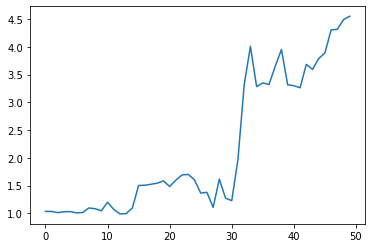

In [430]:
'''
Let's try SGD
'''
init, warm_up, decay = 0.01, 10, 0.999
epochs = 50
warm_up_decay = lambda i: i*(init/warm_up) if i < warm_up  else init*decay**(int((i-warm_up+1)))
# Add noise to the real theta for the starting transformation
theta_init = add_noise(theta_orig,0,0.2)

icp_cloud_sgd, R_list_sgd, T_list_sgd, norms_list, RMS_list_sgd = sgd_icp(source, ref, epochs, 1e-4,
            batch_size=10000, dmax=1,
            show_progress=False, eval_every = 1, theta_init=theta_init,
            alpha = warm_up_decay, beta1=0.9, beta2=0.999, eps=1e-6,
            resample=False)

# plot_clouds(source, ref_orig, icp_cloud_shuffle+ref_mean, drop_rate=0.9 , careful=True)
plt.plot(RMS_list_sgd)

In [429]:
write_ply('/content/SGD_ICP_PY/data/pcd_bremen/my_bremen_sgd_icp.ply', icp_cloud_sgd.T, ['x', 'y', 'z'])
files.download('/content/SGD_ICP_PY/data/pcd_bremen/my_bremen_sgd_icp.ply')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Using Pytorch

In [3]:
'''
ICP using SGD, implemented on PyTorch
'''
def run_icp_pytorch(path_input, theta_orig, noise_level=0.1, epochs=50,
                    batch_size=128, resample=False, matching_technique='torch',
                    plot=False, eval_every=1):
  if '.ply' in path_input:
    source = normalize(read_ply_file(path_input, ['x','y','z']), and_center=True)
  elif '.pcd' in path_input:
    source = normalize(pcd_to_numpy(pcd.point_cloud_from_path(path_input)), and_center=True)
  else:    
    raise Exception('Invalid input format. Only accepting ply and pcd') 

  ref_orig = apply_transform_from_theta(source, theta_orig)
  dif_centers = source.mean(axis=1) - ref_orig.mean(axis=1)
  ref_mean = ref_orig.mean(axis=1).reshape(-1,1)
  ref = ref_orig - ref_mean

  source_torch = torch.tensor(source, dtype=torch.float, device=device)
  ref_torch = torch.tensor(ref, dtype=torch.float, device=device)

  theta_noise = add_noise(theta_orig, 0, noise_level)
  roll_opt = torch.tensor([float(theta_noise[3])], requires_grad=True, device=device)
  pitch_opt = torch.tensor([float(theta_noise[4])], requires_grad=True, device=device)
  yaw_opt = torch.tensor([float(theta_noise[5])], requires_grad=True, device=device)

  T_opt = torch.zeros((3,1), requires_grad=True, device=device)

  angles_optimizer = torch.optim.Adam(params = [roll_opt, pitch_opt, yaw_opt, T_opt])
  # T_optimizer = torch.optim.Adam(params = [T_opt])
  tree, N = KDTree(ref.T), source.shape[1]
  indices = np.arange(N)
  RMS_list = []
  for i in tqdm(range(epochs)):
    
    np.random.shuffle(indices)

    for b in range(N//batch_size):    
      if resample:
        batch_ind = np.random.choice(N, batch_size, replace=False)
      else:
        batch_ind = indices[batch_size*b:batch_size*(b+1)]

      R_opt = rotation_matrix(roll_opt, pitch_opt, yaw_opt, device)

      # Match points
      if matching_technique == 'identity':
        ind = batch_ind.copy()
      else:      
        transformed = (torch.mm(R_opt, source_torch[:,batch_ind])) + T_opt
        if matching_technique == 'torch':
          ind = match_points_pytorch(transformed, ref_torch)
        elif matching_technique == 'kdtree': 
          ind = match_points(transformed.to('cpu').detach().numpy(), tree)
          
      angles_optimizer.zero_grad()    
      loss = torch.norm((torch.mm(R_opt, source_torch[:,batch_ind]) + T_opt) - ref_torch[:,ind], p=2).mean()
      loss.backward()
      angles_optimizer.step()
    
    if (i+1)%eval_every==0:
      with torch.no_grad():
        
        R_opt = rotation_matrix(roll_opt, pitch_opt, yaw_opt, device)
        # Match points
        if matching_technique == 'identity':
          ind = np.arange(N)
        else:      
          transformed = (torch.mm(R_opt, source_torch)) + T_opt
          if matching_technique == 'torch':
            ind = match_points_pytorch(transformed, ref_torch)
          elif matching_technique == 'kdtree': 
            ind = match_points(transformed.to('cpu').detach().numpy(), tree)
        
        loss = torch.norm((torch.mm(R_opt, source_torch) + T_opt) - ref_torch[:,ind], p=2).mean()
        RMS_list.append(loss.item())


  if plot:
    R_opt = rotation_matrix(roll_opt, pitch_opt, yaw_opt, device)
    test = torch.mm(R_opt, source_torch) + T_opt
    plot_clouds(source, ref_orig, test.to('cpu').detach().numpy() + ref_mean, drop_rate = 0.9, careful=False)
  return RMS_list, roll_opt, pitch_opt, yaw_opt, T_opt


def run_icp_pytorch_two_clouds(path_input_source, path_input_ref, theta_init=None, epochs=50,
                    batch_size=128, resample=False, matching_technique='torch',
                    plot=False, eval_every=1):
  if '.ply' in path_input_source:
    source = normalize(read_ply_file(path_input_source, ['x','y','z']), and_center=True)
  elif '.pcd' in path_input_source:
    source = normalize(pcd_to_numpy(pcd.point_cloud_from_path(path_input_source)), and_center=True)
  else:    
    raise Exception('Invalid input format. Only accepting ply and pcd') 


  if '.ply' in path_input_ref:
    ref_orig = normalize(read_ply_file(path_input_ref, ['x','y','z']), and_center=True)
  elif '.pcd' in path_input_ref:
    ref_orig = normalize(pcd_to_numpy(pcd.point_cloud_from_path(path_input_ref)), and_center=True)
  else:    
    raise Exception('Invalid input format. Only accepting ply and pcd') 

  dif_centers = source.mean(axis=1) - ref_orig.mean(axis=1)
  ref_mean = ref_orig.mean(axis=1).reshape(-1,1)
  ref = ref_orig - ref_mean

  source_torch = torch.tensor(source, dtype=torch.float, device=device)
  ref_torch = torch.tensor(ref, dtype=torch.float, device=device)

  if theta_init is None:
    theta_init=np.random.randn(6)
  roll_opt = torch.tensor([float(theta_init[3])], requires_grad=True, device=device)
  pitch_opt = torch.tensor([float(theta_init[4])], requires_grad=True, device=device)
  yaw_opt = torch.tensor([float(theta_init[5])], requires_grad=True, device=device)

  T_opt = torch.zeros((3,1), requires_grad=True, device=device)

  angles_optimizer = torch.optim.Adam(params = [roll_opt, pitch_opt, yaw_opt, T_opt])
  # T_optimizer = torch.optim.Adam(params = [T_opt])
  tree, N = KDTree(ref.T), source.shape[1]
  indices = np.arange(N)
  RMS_list = []
  for i in tqdm(range(epochs)):
    
    np.random.shuffle(indices)

    for b in range(N//batch_size):    
      if resample:
        batch_ind = np.random.choice(N, batch_size, replace=False)
      else:
        batch_ind = indices[batch_size*b:batch_size*(b+1)]

      R_opt = rotation_matrix(roll_opt, pitch_opt, yaw_opt, device)

      # Match points
      if matching_technique == 'identity':
        ind = batch_ind.copy()
      else:      
        transformed = (torch.mm(R_opt, source_torch[:,batch_ind])) + T_opt
        if matching_technique == 'torch':
          ind = match_points_pytorch(transformed, ref_torch)
        elif matching_technique == 'kdtree': 
          ind = match_points(transformed.to('cpu').detach().numpy(), tree)
          
      angles_optimizer.zero_grad()    
      loss = torch.norm((torch.mm(R_opt, source_torch[:,batch_ind]) + T_opt) - ref_torch[:,ind], p=2).mean()
      loss.backward()
      angles_optimizer.step()
    
    if (i+1)%eval_every==0:
      with torch.no_grad():
        
        R_opt = rotation_matrix(roll_opt, pitch_opt, yaw_opt, device)
        # Match points
        if matching_technique == 'identity':
          ind = np.arange(N)
        else:      
          transformed = (torch.mm(R_opt, source_torch)) + T_opt
          if matching_technique == 'torch':
            ind = match_points_pytorch(transformed, ref_torch)
          elif matching_technique == 'kdtree': 
            ind = match_points(transformed.to('cpu').detach().numpy(), tree)
        
        loss = torch.norm((torch.mm(R_opt, source_torch) + T_opt) - ref_torch[:,ind], p=2).mean()
        RMS_list.append(loss.item())


  if plot:
    R_opt = rotation_matrix(roll_opt, pitch_opt, yaw_opt, device)
    test = torch.mm(R_opt, source_torch) + T_opt
    plot_clouds(source, ref_orig, test.to('cpu').detach().numpy() + ref_mean, drop_rate = 0.9, careful=False)
  return RMS_list, roll_opt, pitch_opt, yaw_opt, T_opt

In [ ]:
'''
Define all parameters and run the function to align a cloud and a tranformed version
'''
path_input = '/content/SGD_ICP_PY/data/bunny_original.ply'

# Define the transform (x,y,z,roll,pitch,yaw)
theta_orig = np.array([-1.0,-1.0,+1.0, np.pi/2, np.pi/6*5, np.pi/3])

# Noise to add to the groud truth parameters for the initial guess
noise_level = 5

epochs = 100
batch_size = 1500

# Consume the whole cloud before reshuffling, or resample at every batch step
resample = False

# Matching technique
# Options are
#   'identity': when matching is known
#   'kdtree': Use sklearn KDTree built on the ref cloud
#   'torch': Use matrix torch multiplication to compute distances
matching_technique = 'identity' 

# Plot clouds at the end to see where the aligned cloud is w.r.t source and ref
plot = True

# Frequency to compute total RMS
eval_every = 5

RMS_list, roll_opt, pitch_opt, yaw_opt, T_opt = run_icp_pytorch(path_input, theta_orig, noise_level, epochs,
                    batch_size, resample, matching_technique,
                    plot)

plt.plot(RMS_list)

## Try it on the Bremen cloud

In [ ]:
'''
Define all parameters here
Then execute the next cell
'''
path_input = '/content/SGD_ICP_PY/data/pcd_bremen/my_bremen.pcd'

# Define the transform (x,y,z,roll,pitch,yaw)
theta_orig = np.array([-1.0,-5.0,0.0, np.pi/2, np.pi/6, np.pi/3])

# Noise to add to the groud truth parameters for the initial guess
noise_level = 1

epochs = 20
batch_size = 5000

# Consume the whole cloud before reshuffling, or resample at every batch step
resample = False

# Matching technique
# Options are
#   'identity': when matching is known
#   'kdtree': Use sklearn KDTree built on the ref cloud
#   'torch': Use matrix torch multiplication to compute distances
matching_technique = 'identity' 

# Plot clouds at the end to see where the aligned cloud is w.r.t source and ref
plot = False

# Frequency to compute total RMS
eval_every = 5

RMS_list, roll_opt, pitch_opt, yaw_opt, T_opt = run_icp_pytorch(path_input, theta_orig, noise_level, epochs,
                    batch_size, resample, matching_technique,
                    plot)

plt.plot(RMS_list)

## Try it on the Notre Dame des Champs

In [ ]:
'''
Define all parameters here
Then execute the next cell
'''
path_input_source = '/content/SGD_ICP_PY/data/Notre_Dame_Des_Champs_1.ply'
path_input_ref = '/content/SGD_ICP_PY/data/Notre_Dame_Des_Champs_2.ply'

# Define the initial guess
theta_init = np.array([-0.0,-0.0,0.0, 0.0, 0.0, 0.0])

epochs = 20
batch_size = 5000

# Consume the whole cloud before reshuffling, or resample at every batch step
resample = False

# Matching technique
# Options are
#   'identity': when matching is known
#   'kdtree': Use sklearn KDTree built on the ref cloud
#   'torch': Use matrix torch multiplication to compute distances
matching_technique = 'kdtree' 

# Plot clouds at the end to see where the aligned cloud is w.r.t source and ref
plot = False

# Frequency to compute total RMS
eval_every = 5

RMS_list, roll_opt, pitch_opt, yaw_opt, T_opt = run_icp_pytorch_two_clouds(path_input_source,
                    path_input_ref, theta_init, epochs,
                    batch_size, resample, matching_technique,
                    plot)

plt.plot(RMS_list)